загрузим данные с урока

In [1]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-03-01 21:29:53--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Распознаётся drive.google.com (drive.google.com)... 64.233.162.194, 2a00:1450:4010:c06::c2
Подключение к drive.google.com (drive.google.com)|64.233.162.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jj9messdh33b23dn9785qrh3ig5l215p/1646159325000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-03-01 21:29:54--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jj9messdh33b23dn9785qrh3ig5l215p/1646159325000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Распознаётся doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.251.1.132, 2a00:1450:4010:c1e::84
Подключение к 

In [59]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [25]:
from sklearn.pipeline import FeatureUnion

# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

# 1
Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

In [35]:
result = {}
models = [LogisticRegression(),RandomForestClassifier(),GradientBoostingClassifier()]
for model in models:
    classifier = Pipeline([
        ('features', feats),
        ('classifier', model),
        ])


    # запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score}+-{cv_score_std}')

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    result[f'{model}'] = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763
CV score is 0.7743723744479942+-0.003620133378602203
CV score is 0.8023324413971037+-0.0030701452645104078


In [36]:
result 

{'LogisticRegression()': array([0.21919629, 0.24759828, 0.40484498, ..., 0.16941878, 0.70519218,
        0.75098778]),
 'RandomForestClassifier()': array([0.27583333, 0.14      , 0.02      , ..., 0.03      , 0.82      ,
        0.72      ]),
 'GradientBoostingClassifier()': array([0.1585145 , 0.19609409, 0.36242795, ..., 0.13083914, 0.73939789,
        0.78147122])}

# 2
Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [50]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
table = pd.DataFrame()
keys = ['LogisticRegression()','RandomForestClassifier()','GradientBoostingClassifier()']
for key in keys:
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, result[f'{key}'])
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    table = table.append({'name_model': f'{key}',
               'roc_auc': roc_auc_score(y_test.values, result[f'{key}']),
               'precision': precision[ix],
               'recall': recall[ix],
               'f_score': fscore[ix],
                'Threshold': thresholds[ix]}, ignore_index=True)

In [51]:
table

,Threshold,f_score,name_model,precision,recall,roc_auc
0,0.386937,0.730323,LogisticRegression(),0.647431,0.837558,0.784035
1,0.330000,0.719289,RandomForestClassifier(),0.634395,0.830415,0.769558
2,0.394947,0.740248,GradientBoostingClassifier(),0.697848,0.788134,0.802614


In [57]:
table[table.name_model == 'LogisticRegression()']['Threshold']

0    0.386937
Name: Threshold, dtype: float64

# 3
Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
стоимость лечения 15000р, если сделали тест и начали лечить вовремя
стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
стоимость теста 1400р

In [48]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [49]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


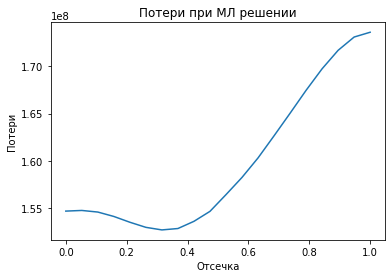

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0    0.386937
Name: Threshold, dtype: float64


In [60]:
thresholds = table[table.name_model == 'LogisticRegression()']['Threshold']
busines_tr = business_threshold_calibrate(y_test, result['LogisticRegression()'], 
                                          thresholds,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 153190600
Расходы "решение не делать тесты - расходы с МL:" 20409400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1509400


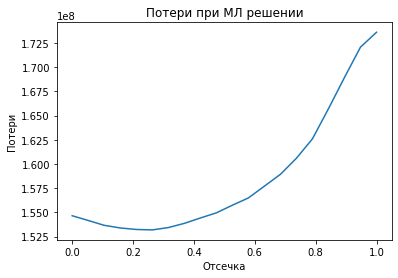

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 1    0.33
Name: Threshold, dtype: float64


In [61]:
thresholds = table[table.name_model == 'RandomForestClassifier()']['Threshold']
busines_tr = business_threshold_calibrate(y_test, result['RandomForestClassifier()'], 
                                          thresholds,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152333600
Расходы "решение не делать тесты - расходы с МL:" 21266400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2366400


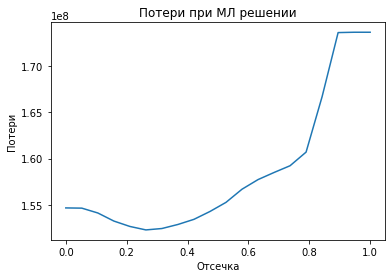

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 2    0.394947
Name: Threshold, dtype: float64


In [62]:
thresholds = table[table.name_model == 'GradientBoostingClassifier()']['Threshold']
busines_tr = business_threshold_calibrate(y_test, result['GradientBoostingClassifier()'], 
                                          thresholds,
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

модель GradientBoostingClassifier() была лучше остальных так как расходы с ML e нее ниже всего